<a href="https://colab.research.google.com/github/ellenwterry/PoliticalAnalysis/blob/main/Campaign_Planning_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please reference the Substack article titled **"Planning and Preparation for the 2024 Generals - Brief"** here: https://substack.com/@ellenterry/posts in conjuntion with this code for context.

The text here is supplemental to that article. So, let's get started.

Load libraries:

In [ ]:
# ---------- Load Libraries ---------- #

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

!pip install nest-asyncio
import nest_asyncio
nest_asyncio.apply()

import patsy
from sklearn.linear_model import LogisticRegression

!pip install pystan
!pip install corner
import stan

import plotly.express as px
import plotly.graph_objects as go

!pip install geopy
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
!pip install pygris
# import matplotlib.pyplot as plt
from pygris import core_based_statistical_areas
from pygris import tracts

from google.colab import files


import geopandas as gpd
import folium
# from google.colab import files


Load demo dataset from github

In [ ]:
# ---------- Get Data from Github ---------- #

url = 'https://raw.githubusercontent.com/ellenwterry/PoliticalAnalysis/main/VoteBase.csv'
VoteBase = pd.read_csv(url)

Prep data for analysis.

In [ ]:
# ---------- Clean up data ---------- #

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(VoteBase['Sex'])

codes = {'NR':0, 'M': 1, 'F': 2}
VoteBase['Sex'] = VoteBase['Sex'].map(codes)

VoteBase['Age']=VoteBase.Age.astype('int32')

#VoteBase['LastPrimary'] = le.transform(VoteBase['LastPrimary'])
codes = {'NR':0, 'R': 1, 'D':2}
VoteBase['LastPrimary'] = VoteBase['LastPrimary'].map(codes)

#VoteBase['Education'] = le.transform(VoteBase['Education'])
codes = {'NR':0, 'HS': 1, 'Some College':2, 'Bachelor':3, 'Masters':4, 'Doctorate':5}
VoteBase['Education'] = VoteBase['Education'].map(codes)

#VoteBase['HHIncome'] = le.transform(VoteBase['HHIncome'])
codes = {'NR':0, 'Under 50k': 1, '50k-100k':2, '100k-200k':3, '200k-300k':4, '300k-500k':5, 'Over 500k':6}
VoteBase['HHIncome'] = VoteBase['HHIncome'].map(codes)

#VoteBase['ReligiousAffil'] = le.transform(VoteBase['ReligiousAffil'])
codes = {'NR':0,'Protestant': 1, 'Catholic':2, 'Other':3, 'None':4}
VoteBase['ReligiousAffil'] = VoteBase['ReligiousAffil'].map(codes)

#VoteBase['Support24'] = le.transform(VoteBase['Support24'])
codes = {'R':0, 'D': 1}
VoteBase['Support24'] = VoteBase['Support24'].map(codes)
# NOTE: NAs were excluded from sample so that algorithms could score using logistic scale - 2nd pass will use imputed values

#VoteBase['TopIssue'] = le.transform(VoteBase['TopIssue'])
codes = {'NR':0, 'RFree':1, 'Parents':2, 'Crime':3, 'Economy':4, 'Womens':5, 'Education':6, 'Environment':7, 'Democracy':8}
VoteBase['TopIssue'] = VoteBase['TopIssue'].map(codes)

# This is for the second data source (later)
codes = {'NS':0, 'NR':1,'Signed':2}
VoteBase['RRPetition'] = VoteBase['RRPetition'].map(codes)

Transform data to model matrix for Stan based logistic regression

In [ ]:
# ---------- Create Matrices for Modeling ---------- #

yDf = VoteBase['Support24']
Xmatrix = patsy.dmatrix('Age + Sex + Education + HHIncome+ ReligiousAffil + LastPrimary + TopIssue', VoteBase)
rows = Xmatrix.shape[0]
columns = Xmatrix.shape[1]
rows, columns


(2498, 8)

# Iteration 1 *(Uninformed Priors)*
...and we build the first model. This is Bayesian logistic regression - we're using the '24support' dependent variable to tune the independent variable relationships, so that we can understand effects.

>The **data section** of the model sets up the data structure.

>The **parameters and transformed parameters** sections manage the parameters and create the equations we'll use *(regression in this case)*, and prepare the structures for iteration through observations *(it's really doing a lot of work for the model section)*

>The **model section** sets up the distributions *(bernoulli here to reflect the logistic equation)* to produce a target posterior distribution.

Keep in mind, the Bayesian Model

> ***posterior = data x prior***

If you look at **target += normal_lpdf(beta | p_b, p_sb);**, the **posterior is the target (distribution)**, **beta is the matrix of data** and **p_b and p_sb are the prior parameters with variances**. So, we actually are multiplying the data by the prior distribution parameters to get a posterior distribution. We won't know what the posterior distribution looks like until we sample it to define those parameters *(that's what the Stan program is doing for us - you can think of sampling like a random walk)*


In [ ]:
# ---------- Load Model 1 ---------- #

stanMod = """
data {
  int N_train;
  int K;
  int y_train[N_train];
  matrix[N_train, K] x_train;
  real p_b[K];
  real p_sb[K];
}
parameters {
  vector[K] beta;
}
transformed parameters {
  vector[N_train] y_hat;
  for(n in 1:N_train)
    y_hat[n] = x_train[n]*beta;
}
model {
  target += normal_lpdf(beta | p_b, p_sb);
  target += bernoulli_lpmf(y_train | inv_logit(y_hat));
}
"""

This is where we feed the data into the model.

I'm defining ***uninformed priors*** here - a common starting point if you have no experience with the data - i.e., an unbiased starting point: in the code **priors = np.repeat(0, 8)**, I set all the pior parameters to 0, and with **priorsSigma = np.repeat(2, 8)**, I set the standard deviation of all the the parameters to 2, which is wide open for these parameters and gives the sampler plenty of room to roam. Then we'll see what the data tells us:

In [ ]:
# ---------- Create Uninformed Priors ---------- #

priors = np.repeat(0, 8)
priorsSigma = np.repeat(2, 8)

mData = {
         "N_train": rows,
         "K": np.shape(Xmatrix)[1],
         "y_train": np.array(yDf),
         "x_train": Xmatrix,
          "p_b": priors,
          "p_sb": priorsSigma,
         }

Compile the model *(the stan program is running in C under the hood)*

In [ ]:
# Compile the Model
postr = stan.build(stanMod, data = mData, random_seed = 1)

...and run the sampler:

In [ ]:
# Muliply Prior and Data - Sample Prosterior
fit = postr.sample(num_chains=4, num_samples=1000)

OK, now we can pull the posterior parameters out. That's what we'll be working with from now on, and we can "tweak" the modeling process from here.  

Also, notice the  statements:

>**def stable_sigmoid(x):
  return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))**


>**stanProb = stable_sigmoid((np.dot(priors,Xmatrix.transpose())).transpose())**

This is what creates our probabilities - We use the parameters from the posterior  and run the data through the parameters. These statements are just a python version of the logistic equation:

>**𝑃(𝑌)=𝑒𝑥𝑝(𝛽0+𝛽𝑛𝑋𝑛)/𝑒𝑥𝑝(1+𝑒𝑥𝑝(𝛽0+𝛽𝑋𝑛)**

>Note: There are many advantages to generating predictions and probabilities outside of packages/programs/algorithms *(e.g., in high transaction, dynamic environments, analysts will often run analysis models in parallel with production models and pass parameters between the models to keep them relevant to the minute)*. There's also security and transaction management issues - which is why many IT shops wouldn't allow R or Python in production *(big, touchy subject outside of this discussion)*

Now that we have the probabilities *(of voting for the D candidate)*, we store those in a "StanProb" column. I have also stored a theoretical vote *(discrete variable)* based on a 50% threshold - just for comparative metrics.

In [ ]:
# Get Parameters
df = fit.to_frame()
Params = df.describe().T
beta1 = Params['mean']['beta.1']
beta2 = Params['mean']['beta.2']
beta3 = Params['mean']['beta.3']
beta4 = Params['mean']['beta.4']
beta5 = Params['mean']['beta.5']
beta6 = Params['mean']['beta.6']
beta7 = Params['mean']['beta.7']
beta8 = Params['mean']['beta.8']
priors = np.array([beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8])

beta1Std = Params['std']['beta.1']
beta2Std = Params['std']['beta.2']
beta3Std = Params['std']['beta.3']
beta4Std = Params['std']['beta.4']
beta5Std = Params['std']['beta.5']
beta6Std = Params['std']['beta.6']
beta7Std = Params['std']['beta.7']
beta8Std = Params['std']['beta.8']
priorsSigma = np.array([beta1Std, beta2Std, beta3Std, beta4Std, beta5Std, beta6Std, beta7Std, beta8Std])

def stable_sigmoid(x):
  # Using np.where to avoid numerical overflow or underflow.
  return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

# Create Inferred Votes
stanProb = stable_sigmoid((np.dot(priors,Xmatrix.transpose())).transpose())


def updateInferredVote(x):
  if x >= .5:
    return 1
  else:
    return 0

VoteBase['StanProb'] = stanProb
VoteBase['StanVote'] = VoteBase['StanProb'].apply(updateInferredVote)


...and here's the parameters of Model 1's posterior distribution. First, keep in mind the order in the matrix: the Intercept *(garbage collection - i.e., what's left over)*, and 'Age + Sex + Education + HHIncome+ ReligiousAffil + LastPrimary + TopIssue'. So, based on the raw data, the model thinks that Education, HouseHold Income and Religious Affiliation are the most significant independents. That's all good, but there are a few problems:

>1. Education and HHIncome are really too correlated *(and should be transformed to a composite variable, but we won't do that now)*.

>2. We're interested in exploring issue effects here - starting with **Women's Healthcare**. The only variable semi-addressing issues now is TopIssue which is not great because the "Womens" selection was recorded by a volunteer, and it's one of many choices.

we're going to make some adjustments to mitigate some of these issues.

We take the models parameters, and call them "priors" because we're going to turn around and use them again *(with some adjustment)* for the next model.

While we're discussing independent variables - there are many ways to visualize variable associations - I like box plots here for visualizing the Top Issue distribtuions:

In [ ]:
fig = px.box(VoteBase, x='TopIssue', y='StanProb', points="all")
fig.update_layout(
    width=1000,
    height=500,
    plot_bgcolor = "white",
    xaxis = dict(
        tickmode = 'array',
        title='Top Issue',
        tickvals = [0, 1, 2, 3, 4, 5, 6, 7, 8],
        ticktext = ['NR', 'RFree', 'Parents', 'Crime', 'Economy', 'Womens', 'Education', 'Environment', 'Democracy']
    ),
        yaxis=dict(title='Probability of Vote',),
)
fig.show()


But let's drill down on Womens Healthcare, and combine that with the distribtuion of voters that signed a petititon. Then let's combine the 2: Is that a group that would be a good target for leaders on this issue?

# Iteration 2 *(Adjusting Priors)*

Our demo campaign has prepared a survey to ask voters to sign a petition to tell leaders that they support reproductive healthcare choices. We'll add that data when it's done, but for now, the campaign has to assign block turf and phonebanks. So, let's use a temp substitute varialbe to emphasize gender. Summarizing the adjustments:

>increasing priors[2], which is 'Sex', to impute the "Ohio Effect" so we can start scheduling assgiments and campaign

>decreasing priors[4] to decrease the effect of 'HHIncome' - it's too correlated with Edcuation and overemphasized.

>increasing priors[7] to increase the effect of Issues -that's the driver we're interested in and the effects are not prominent enough.

In [ ]:
priors2 = priors.copy()
priors2[2] = 0.1
priors2[4] = 0.3
priors2[7] = 0.2
priorsSigma2 = priorsSigma.copy()
priorsSigma2[2] = 0.02
priorsSigma2[4] = 0.02
priorsSigma2[7] = 0.02

# Emphasize Sex (temp), and TopIssue, De-emphasize HHIncome (which is overstated because of corelation with education and being a continous variable)

Reset the priors...

In [ ]:
mData = {
         "N_train": rows,
         "K": np.shape(Xmatrix)[1],
         "y_train": np.array(yDf),
         "x_train": Xmatrix,
          "p_b": priors2,
          "p_sb": priorsSigma2,
         }


...and run the model:

In [ ]:
# Compile the Model
postr = stan.build(stanMod, data = mData, random_seed = 1)

In [ ]:
# Muliply Prior and Data - Sample Prosterior
fit = postr.sample(num_chains=4, num_samples=1000)

Get the parameters and compute probabilities *(if you look at the data now, you'll see that the probabilities increased with many voters - we'll see all this later)*

In [ ]:
# Get Parameters
df = fit.to_frame()
Params = df.describe().T
beta1 = Params['mean']['beta.1']
beta2 = Params['mean']['beta.2']
beta3 = Params['mean']['beta.3']
beta4 = Params['mean']['beta.4']
beta5 = Params['mean']['beta.5']
beta6 = Params['mean']['beta.6']
beta7 = Params['mean']['beta.7']
beta8 = Params['mean']['beta.8']
priors2 = np.array([beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8])

beta1Std = Params['std']['beta.1']
beta2Std = Params['std']['beta.2']
beta3Std = Params['std']['beta.3']
beta4Std = Params['std']['beta.4']
beta5Std = Params['std']['beta.5']
beta6Std = Params['std']['beta.6']
beta7Std = Params['std']['beta.7']
beta8Std = Params['std']['beta.8']
priorsSigma2 = np.array([beta1Std, beta2Std, beta3Std, beta4Std, beta5Std, beta6Std, beta7Std, beta8Std])

def stable_sigmoid(x):
  # Using np.where to avoid numerical overflow or underflow.
  return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

# Create Inferred Votes
stanProb2 = stable_sigmoid((np.dot(priors2,Xmatrix.transpose())).transpose())


def updateInferredVote(x):
  if x >= .5:
    return 1
  else:
    return 0

VoteBase['StanProb2'] = stanProb2
VoteBase['StanVote2'] = VoteBase['StanProb2'].apply(updateInferredVote)


We'll compare interation 2 results along with iteratinon 3. So let's keep going.


In [ ]:
Xmatrix = patsy.dmatrix('Age + Sex + Education + HHIncome+ ReligiousAffil + LastPrimary + TopIssue + RRPetition', VoteBase)
rows = Xmatrix.shape[0]
columns = Xmatrix.shape[1]

# Iteration 3 *(Integrating the Petition Data)*

OK, our demo campaign has finished the survey and we have the data. Now, we can add that to our model, so we can release the priors on Sex

>priorsSigma3[2] = 0.2 #open this up now that we have the petition



Increasing the Sex dimension boosted women voters, some of which popped into the persuadable universe *(we'll be quantifying that as >40% likelihood later in group assignments)*. Just being 'F' isnt' enough - the model looks at religion, income, last primary, etc. and balances the effect of all the variables with an emphasized Sex value. That's helpful, but there are many men who should be moving into the persuadable universe too, and the model won't pick that up.


Last time:

In [ ]:
priors3 = np.append(priors2[0:8], .4)
priorsSigma3 = np.append(priorsSigma2[0:8], .02)
priorsSigma3[2] = 0.2 #open this up now that we have the petition

In [ ]:
mData = {
         "N_train": rows,
         "K": np.shape(Xmatrix)[1],
         "y_train": np.array(yDf),
         "x_train": Xmatrix,
          "p_b": priors3,
          "p_sb": priorsSigma3,
         }

In [ ]:
postr = stan.build(stanMod, data = mData, random_seed = 1)

In [ ]:
fit = postr.sample(num_chains=4, num_samples=1000)

pull the parameters and compute probabilities again:

In [ ]:
df = fit.to_frame()
Params = df.describe().T
beta1 = Params['mean']['beta.1']
beta2 = Params['mean']['beta.2']
beta3 = Params['mean']['beta.3']
beta4 = Params['mean']['beta.4']
beta5 = Params['mean']['beta.5']
beta6 = Params['mean']['beta.6']
beta7 = Params['mean']['beta.7']
beta8 = Params['mean']['beta.8']
beta9 = Params['mean']['beta.9']
priors3 = np.array([beta1, beta2, beta3, beta4, beta5, beta6, beta7, beta8, beta9])

beta1Std = Params['std']['beta.1']
beta2Std = Params['std']['beta.2']
beta3Std = Params['std']['beta.3']
beta4Std = Params['std']['beta.4']
beta5Std = Params['std']['beta.5']
beta6Std = Params['std']['beta.6']
beta7Std = Params['std']['beta.7']
beta8Std = Params['std']['beta.8']
beta9Std = Params['std']['beta.9']
priorsSigma3 = np.array([beta1Std, beta2Std, beta3Std, beta4Std, beta5Std, beta6Std, beta7Std, beta8Std, beta9Std])

def stable_sigmoid(x):
  # Using np.where to avoid numerical overflow or underflow.
  return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

# Create Inferred Votes
stanProb3 = stable_sigmoid((np.dot(priors3,Xmatrix.transpose())).transpose())

def updateInferredVote(x):
  if x >= .5:
    return 1
  else:
    return 0

VoteBase['StanProb3'] = stanProb3
VoteBase['StanVote3'] = VoteBase['StanProb3'].apply(updateInferredVote)

and here's the migration of parameters from the first to the third model:

In [ ]:
priors = np.append(priors, np.nan)
priors2 = np.append(priors2, np.nan)

priorsSigma = np.append(priorsSigma, np.nan)
priorsSigma2 = np.append(priorsSigma2, np.nan)

priorsDF = pd.DataFrame({"priors": priors, "priorsSigma": priorsSigma, "priors2": priors2, "priorsSigma2": priorsSigma2, "priors3": priors3, "priorsSigma3": priorsSigma3})

priorsDF


,priors,priorsSigma,priors2,priorsSigma2,priors3,priorsSigma3
0,-4.608779,0.329315,-3.919789,0.161765,-3.979436,0.128638
1,-0.006715,0.003256,-0.004411,0.002122,-0.004422,0.001609
2,0.069156,0.114350,0.105275,0.019978,0.047830,0.080867
3,0.284556,0.052345,0.358541,0.035013,0.362764,0.028484
4,0.783808,0.081159,0.340060,0.018740,0.363792,0.017583
5,0.977975,0.055100,1.030467,0.037717,1.034660,0.029690
6,0.405648,0.102011,0.406445,0.070434,0.405128,0.058126
7,0.131926,0.026831,0.179525,0.015607,0.166438,0.013396
8,NaN,NaN,NaN,NaN,0.387693,0.019997


Another way to look at this migration, is to view the shift in probabilities. Some voters that you might not talk to initiatlly, have shifted into persuadable groups. Note how the bins in the lower probability shift down, and the bins in the middle, up and to the right.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=VoteBase['StanProb'], marker_color='#DEDCDC', opacity=0.05, name = "Iteration 1"))
fig.add_trace(go.Histogram(x=VoteBase['StanProb2'], marker_color='#94CDD7', opacity=0.1, name = "Iteration 2"))
fig.add_trace(go.Histogram(x=VoteBase['StanProb3'], marker_color='#378796', opacity=1, name = "Iteration 3"))
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.9, nbinsx=100)
fig.update_layout(
    autosize=False,
    width=800,
    height=400,
    plot_bgcolor = "white",
    xaxis=dict(title='Probability of Vote',),
)

fig.show()

So, here's where we get to the action. This is how we shift focus backed by statistics and probablity. In this demo, the numbers don't look overwhelmeing, but when you start running real numbers through, this is critical.

In [ ]:
fig = go.Figure()

t1 = go.Box(
    y=VoteBase.loc[VoteBase['TopIssue'] == 5, 'StanProb3'],
    name="TopIssue: Womens",
    jitter=0.9,
    pointpos=-0,
    boxpoints='all', # represent all points
    marker = dict(color = 'rgb(242, 41, 128)'),
    line = dict(color = 'rgba(0,0,0,0)'),
    fillcolor = 'rgba(0,0,0,0)'
)

t2 = go.Box(
    y=VoteBase.loc[VoteBase['RRPetition'] == 2, 'StanProb3'],
    name="Petititon Signed",
    jitter=0.9,
    pointpos=0,
    boxpoints='all', # represent all points
    marker = dict(color = 'rgb(192, 41, 242)'),
    line = dict(color = 'rgba(0,0,0,0)'),
    fillcolor = 'rgba(0,0,0,0)'
)

t3 = go.Box(
    y = VoteBase.loc[(VoteBase['TopIssue'] == 5) & (VoteBase['RRPetition'] == 2), "StanProb3"],
    name="Both",
    jitter=0.9,
    pointpos=0,
    boxpoints='all', # represent all points
    marker = dict(color = 'rgb(41, 95, 242)'),
    line = dict(color = 'rgba(0,0,0,0)'),
    fillcolor = 'rgba(0,0,0,0)'
)

fig.update_layout(title_text="Box Plot Styling Outliers")
data = [t1, t2, t3]
layout = go.Layout(width=800, height=500, plot_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data, layout)
fig.show()

In [ ]:
fig = go.Figure()

t1 = go.Box(
    y = VoteBase.loc[(VoteBase['TopIssue'] == 5) & (VoteBase['RRPetition'] == 2) & (VoteBase['StanProb'] > .4), "StanProb"],
    name="Womens Issue Voters",
    jitter=0.9,
    pointpos=0,
    boxpoints='all', # represent all points
    marker = dict(color = 'rgb(208, 202, 250)'),
    line = dict(color = 'rgba(0,0,0,0)'),
    fillcolor = 'rgba(0,0,0,0)'
)

t2 = go.Box(
    y = VoteBase.loc[(VoteBase['TopIssue'] == 5) & (VoteBase['RRPetition'] == 2) & (VoteBase['StanProb'] > .4), "StanProb3"],
    name="Womens Issue Voters",
    jitter=0.9,
    pointpos=0,
    boxpoints='all', # represent all points
    marker = dict(color = 'rgb(41, 95, 242)'),
    line = dict(color = 'rgba(0,0,0,0)'),
    fillcolor = 'rgba(0,0,0,0)'
)

fig.update_layout(title_text="Box Plot Styling Outliers")
data = [t1, t2]
layout = go.Layout(width=800, height=500, plot_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data, layout)
fig.show()

Giving "Womens Healthcare" as your top issue and signing a petition are strong indicators of an intent to vote D. Initially, the model didn't see it that way, so we increased the effect of those paramters using priors. Doing so, forces the model to "rebalance" all the parametes. So, not all voters increase, some decrease. Here's a sample of each direction:

In [ ]:
fig = go.Figure()

t1 = go.Box(
    y = VoteBase.loc[VoteBase['ID'].isin([254,1083]),"StanProb"],
    pointpos=0,
    name="First Iteration",
    boxpoints='all', # represent all points
    marker = dict(color = 'rgb(208, 202, 250)'),
    line = dict(color = 'rgba(0,0,0,0)'),
    fillcolor = 'rgba(0,0,0,0)'
)

t2 = go.Box(
    y = VoteBase.loc[VoteBase['ID'].isin([254,1083]),"StanProb2"],
    pointpos=0,
    name="Second Iteration",
    boxpoints='all', # represent all points
    marker = dict(color = 'rgb(119, 166, 242)'),
    line = dict(color = 'rgba(0,0,0,0)'),
    fillcolor = 'rgba(0,0,0,0)'
)

t3 = go.Box(
    y = VoteBase.loc[VoteBase['ID'].isin([254,1083]),"StanProb3"],
    pointpos=0,
    name="Last Iteration",
    boxpoints='all', # represent all points
    marker = dict(color = 'rgb(41, 95, 242)'),
    line = dict(color = 'rgba(0,0,0,0)'),
    fillcolor = 'rgba(0,0,0,0)'
)

data = [t1, t2, t3]
layout = go.Layout(width=800, height=500, plot_bgcolor='rgba(0,0,0,0)')
fig = go.Figure(data, layout)
fig.show()

Not every voter gets pushed up by the "tweaks". Here are two independents that responded to the survey that they planed to vote R in 24. But given, their location, age, education, HHIncome and Religious Affiliation, the model gave them probabilities of voiting D around 40%. After tweaking, which told the model to value signing a petition higher, the first voter moved down a bit because of a 'NR', while second voter moved up to 48% because of the 'Signed'.  

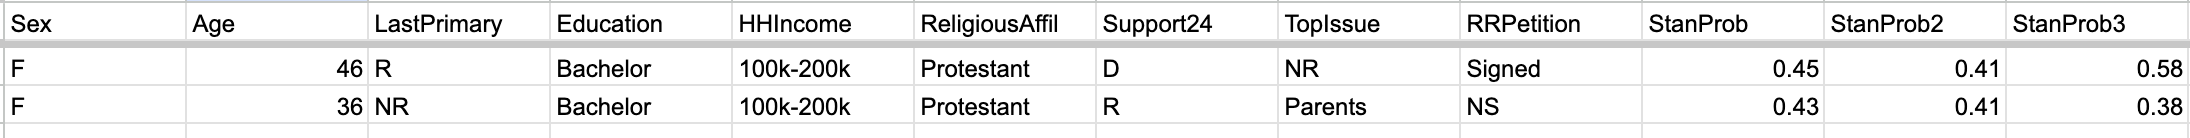

We can bin the voters into groups to make it easier to make canvassing assignments. Here, we're cutting out voters below 40% probability, and then binning into Leaners (mostly indies), Base, and Leader groups:

In [ ]:
bins = [0, .4, .5, .9, 1]
labels = ['None', 'Leaners', 'Base', 'Leaders']
VoteBase['InitialGroup'] = pd.cut(x = VoteBase['StanProb'], bins = bins, labels = labels, include_lowest = False)
VoteBase['Group'] = pd.cut(x = VoteBase['StanProb3'], bins = bins, labels = labels, include_lowest = False)

In [ ]:
VoteBase.to_csv('VoteBaseCompare.csv')
files.download("VoteBaseCompare.csv")
priorsDF.to_csv("PriorsDF.csv")
files.download("PriorsDF.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Create Interest Groups

In [ ]:
# Assign to Interest Groups (just 2 issues here)

WomensBase = VoteBase.loc[((VoteBase['Group'] == 'Leaders') | (VoteBase['Group'] == 'Base') | (VoteBase['Group'] == 'Leaners'))& (VoteBase['TopIssue'] == 5)]
WomensBase = WomensBase.reset_index()



In [ ]:
WomensBase

,index,ID,Name,Sex,Age,LastPrimary,Latitude,Longitude,Education,HHIncome,...,TopIssue,RRPetition,StanProb,StanVote,StanProb2,StanVote2,StanProb3,StanVote3,InitialGroup,Group
0,16,17,Voter 17,2,33,0,41.04118,-73.56972,3,3,...,5,2,0.956251,1,0.963048,1,0.980085,1,Leaders,Leaders
1,17,18,Voter 18,1,69,1,41.03117,-73.62782,2,1,...,5,1,0.586410,1,0.791458,1,0.829430,1,Base,Base
2,30,31,Voter 31,1,35,0,41.05629,-73.58218,1,2,...,5,2,0.838762,1,0.889854,1,0.939924,1,Base,Leaders
3,31,32,Voter 32,2,35,0,41.04586,-73.60852,1,2,...,5,2,0.847897,1,0.899757,1,0.942569,1,Base,Leaders
4,32,33,Voter 33,1,56,0,41.02816,-73.61879,0,2,...,5,2,0.772673,1,0.837274,1,0.908426,1,Base,Leaders
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,2477,2478,Voter 2478,2,32,0,41.04666,-73.59489,5,6,...,5,2,0.993528,1,0.981507,1,0.990832,1,Leaders,Leaders
310,2479,2480,Voter 2480,1,37,0,41.03658,-73.57347,3,6,...,5,0,0.995227,1,0.984598,1,0.984429,1,Leaders,Leaders
311,2487,2488,Voter 2488,2,55,2,41.03167,-73.59768,3,3,...,5,2,0.976980,1,0.981591,1,0.990138,1,Leaders,Leaders
312,2493,2494,Voter 2494,2,62,0,41.07108,-73.63842,4,3,...,5,1,0.959858,1,0.970434,1,0.976865,1,Leaders,Leaders


Interest Groups are networking structures to engage the base and the indie leaners. Most likely, campaigns will want to recruit these groups by phone and email *(finding leaders first, and letting them build the group)*. The groups could then be integrated with canvassing to address specific issues in the field:

In [ ]:
m = folium.Map(width=1000,height=800,location=[41.07, -73.6], zoom_start=12)

for i in range(VoteBase[VoteBase.columns[0]].count()):
  folium.CircleMarker(
    [VoteBase['Latitude'][i], VoteBase['Longitude'][i]], radius = 1, weight = 2, color = "gray").add_to(m)

for i in range(WomensBase[WomensBase.columns[0]].count()):
  folium.CircleMarker(
    [WomensBase['Latitude'][i], WomensBase['Longitude'][i]], radius = 1, weight = 2, color = "red").add_to(m)

#for i in range(EnvironmentBase[EnvironmentBase.columns[0]].count()):
#  folium.CircleMarker(
#    [EnvironmentBase['Latitude'][i], EnvironmentBase['Longitude'][i]], radius = 3, weight = 2, color = "green").add_to(m)

m

Finally, if you're wondering how many voters moved up groups from model 1 to model3, the number is 88:

In [ ]:
VoteBase['StanVote2'].sum()

1363

Summing up the vote goal issue: If we used a 50% probability to assign a D vote, we'd predict 1,287 just running a plain logistic model *(I also ran the Scikit-learn logistic model and got the same thing as the first model)*.

In this demo precinct of 2500, we would typically set a vote goal at 50% + 5% cushion, so 1,375 would be the target. The final model predicted 1,309 votes, but we now have groups of persuadables to contact that wouldn't have shown up - and based on the confounders at play, it seems like these persuadables are a good target. It's going to be tight, but winnable!      

Thanks for reading and please let me know of any comments or questions.